In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dalex as dx
import scipy
import optuna

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from catboost import CatBoostClassifier
from statsmodels.tools.tools import add_constant
from matplotlib import style
from optuna.integration import CatBoostPruningCallback

plt.style.use('dark_background')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['red'])

In [2]:
#loading data
df = pd.read_csv('./BankChurners.csv')
df.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], inplace=True)

#setting y to 0-1 binary variable
df['Attrition_Flag'].mask(df['Attrition_Flag'] == 'Existing Customer', 0, inplace=True)
df['Attrition_Flag'].mask(df['Attrition_Flag'] == 'Attrited Customer', 1, inplace=True)

#defining and splitting variables
X = df.drop(columns=['CLIENTNUM', 'Attrition_Flag'])
y = df['Attrition_Flag'].astype(float)

#used stratified, because of the distribution of y (it's skewed)
idx_train, idx_rest = train_test_split(X.index, stratify=y, random_state=999, test_size=0.3)

X_train, X_rest = X.loc[idx_train], X.loc[idx_rest]
y_train, y_rest = y[idx_train], y[idx_rest]

idx_test, idx_val = train_test_split(X_rest.index, stratify=y_rest, random_state=999, test_size=0.5)

X_test, X_val = X.loc[idx_test], X.loc[idx_val]
y_test, y_val = y[idx_test], y[idx_val]

#selecting numerical and categorical columns
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X_train.select_dtypes(include='object').columns

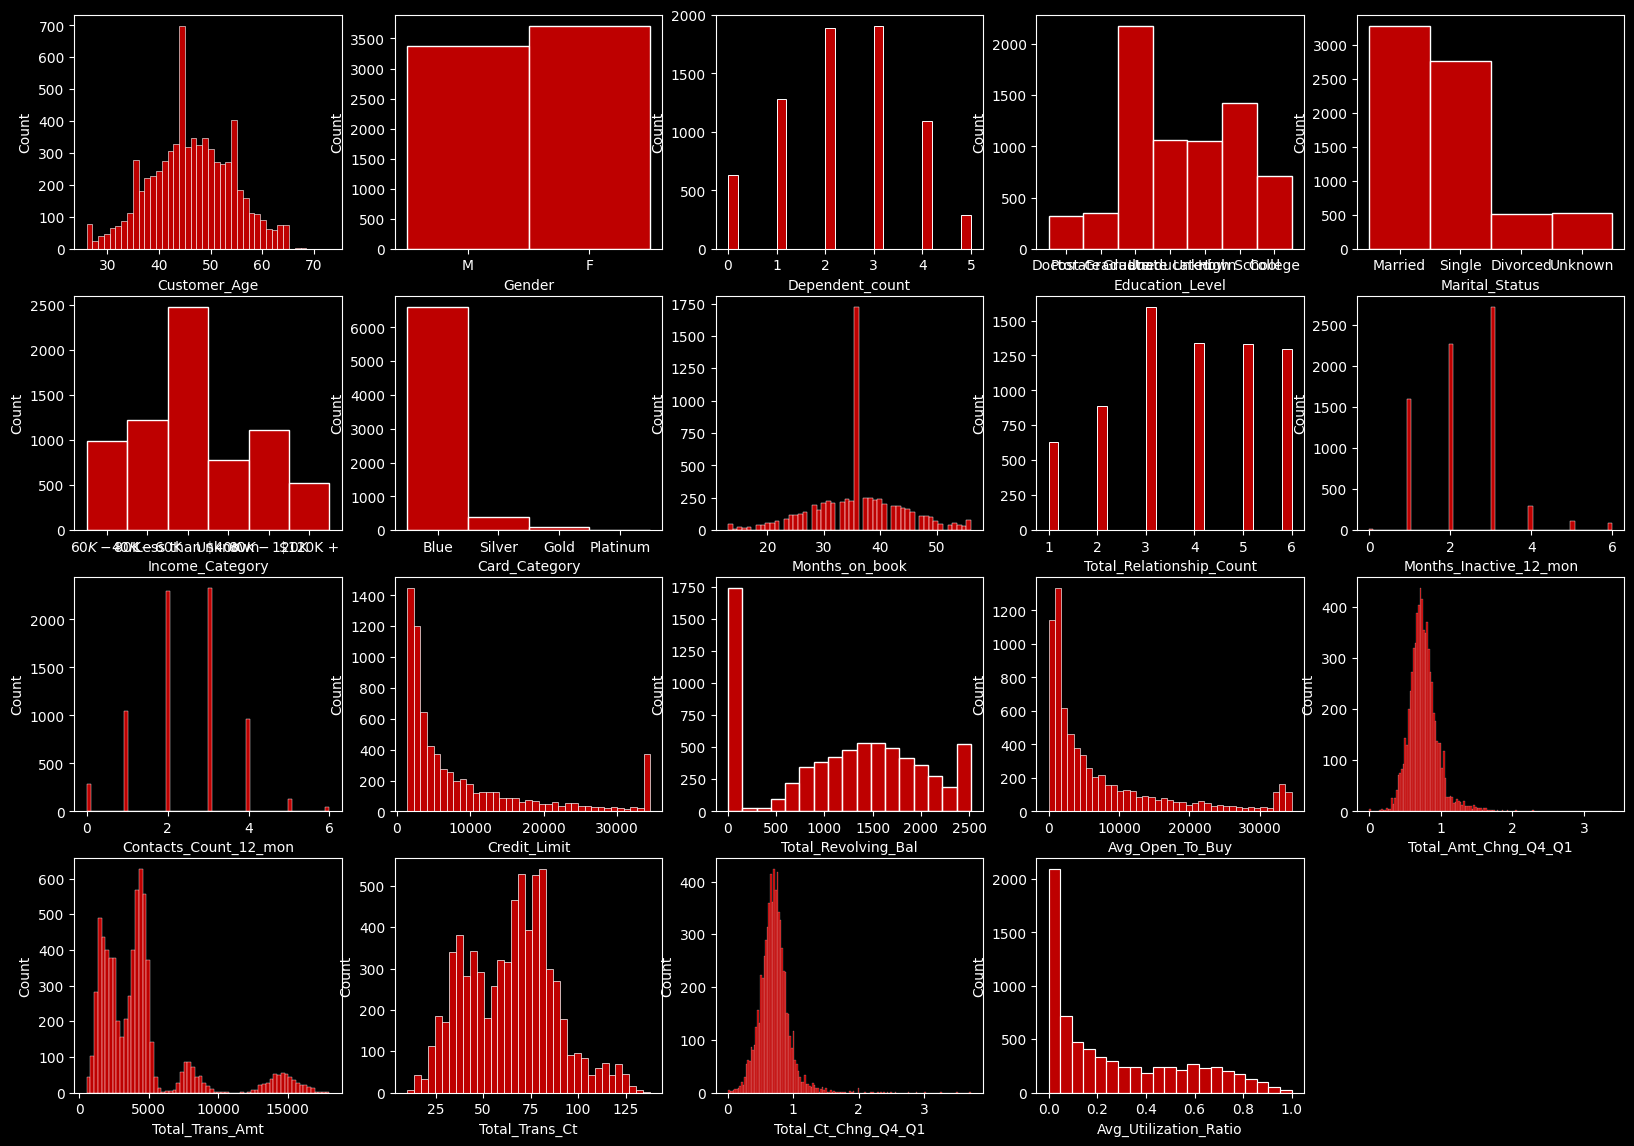

In [3]:
#displaying distribution of the data

plt.figure(figsize=(20,14))
k=1
for i in X_train.columns:
    plt.subplot(4,5,k)
    sns.histplot(X_train[i])
    k+=1

plt.show()

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

encoder = OneHotEncoder(sparse_output=False, handle_unknown="error", dtype=float).set_output(transform="pandas")

one_hot_encoded_train = encoder.fit_transform(X_train[categorical_columns])
one_hot_encoded_val = encoder.transform(X_val[categorical_columns])
one_hot_encoded_test = encoder.transform(X_test[categorical_columns])

X_train.drop(columns=categorical_columns, inplace=True)
X_val.drop(columns=categorical_columns, inplace=True)
X_test.drop(columns=categorical_columns, inplace=True)

X_train = pd.concat([X_train, one_hot_encoded_train], axis=1)
X_val = pd.concat([X_val, one_hot_encoded_val], axis=1)
X_test = pd.concat([X_test, one_hot_encoded_test], axis=1)

In [5]:
#building model
model = CatBoostClassifier(verbose=False)
model_fitted = model.fit(X_train, y_train)
y_pred = model.predict(X_val)

In [6]:
#initializing explainer 

model_exp = dx.Explainer(model_fitted, X_train, y_train, label='CBC')

Preparation of a new explainer is initiated

  -> data              : 7088 rows 37 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 7088 values
  -> model_class       : catboost.core.CatBoostClassifier (default)
  -> label             : CBC
  -> predict function  : <function yhat_proba_default at 0x0000019A9BEDE050> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 3.9e-06, mean = 0.161, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.819, mean = 4.41e-05, max = 0.794
  -> model_info        : package catboost

A new explainer has been created!


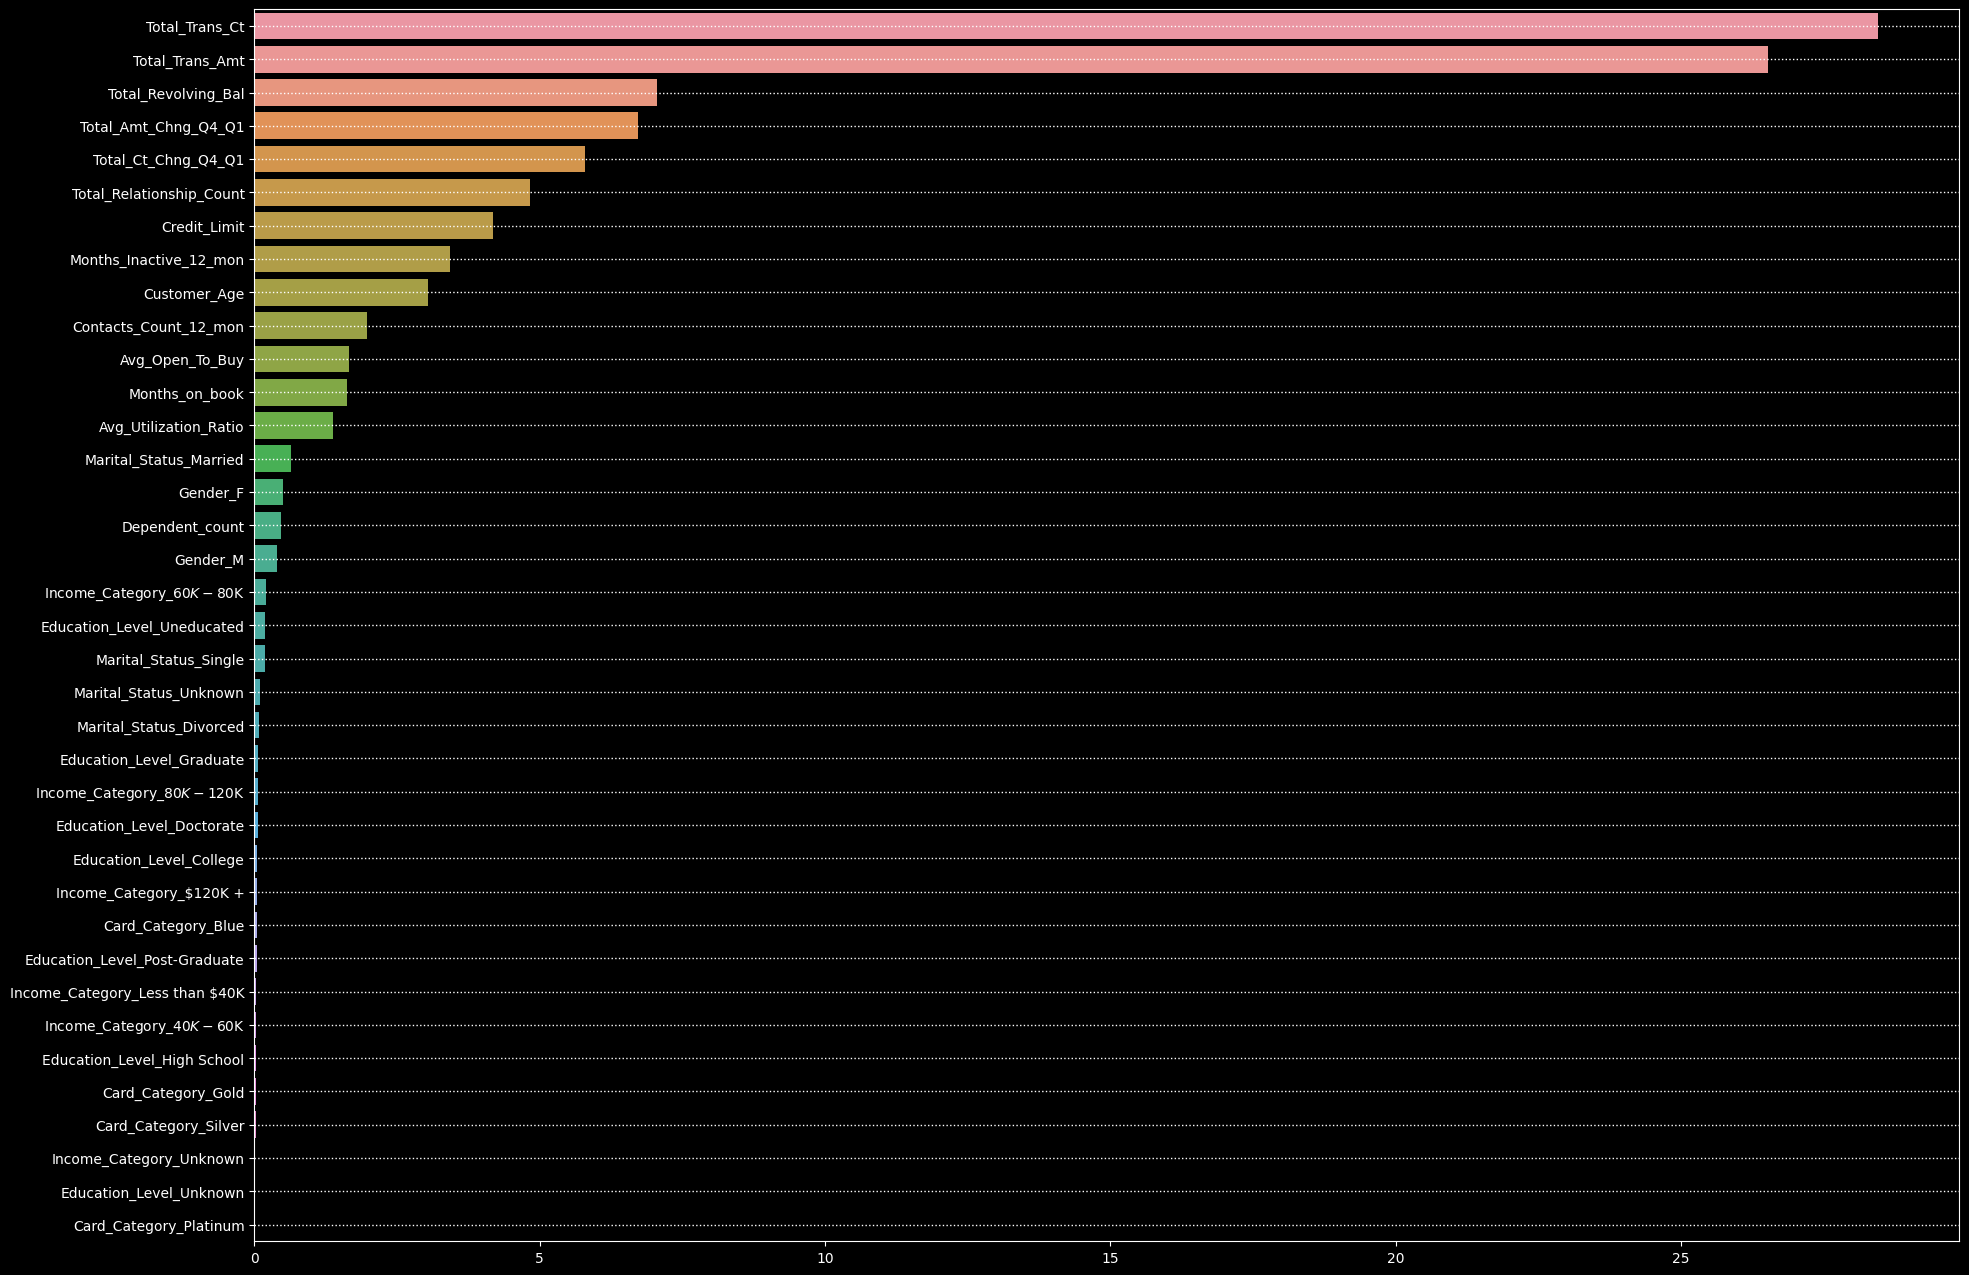

In [7]:
importances = pd.DataFrame(model_fitted.feature_importances_.reshape(1,-1), columns=X_train.columns)
plt.figure(figsize=(22,16))
sns.barplot(data=importances.sort_values(by=[0], axis=1, ascending=False), orient='h')
plt.grid(axis='y', color='white', linestyle='dotted', lw=1)
plt.show()

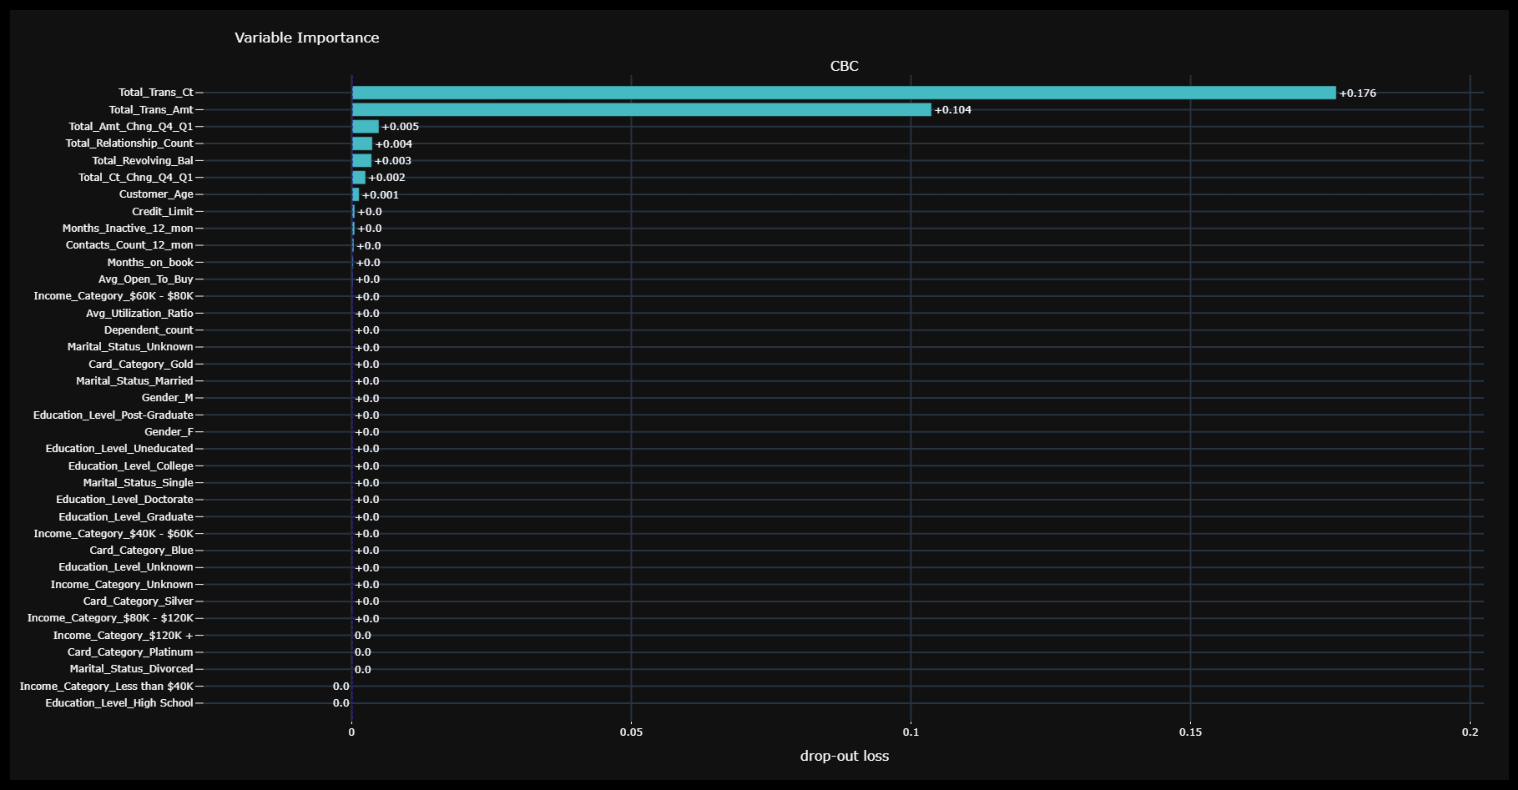

In [33]:
#permutation-based importances
model_exp_importances = model_exp.model_parts()
#dynamic plot
#model_exp_importances.plot(max_vars=None, show=False).update_layout(template='plotly_dark', font_color='white')

#displaying static plot (to make it visible in github)
import matplotlib.image as mpimg
img = mpimg.imread("C:/Users/pc/Churn-Classification/Static_Plots/importances.png")
plt.figure(figsize=(25,10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Next step is dropping all the features which are least important from the above plot.

In [9]:
model_exp_importances.result = model_exp_importances.result[~model_exp_importances.result['variable'].isin(['_baseline_', '_full_model_'])].drop(columns='label').sort_values(by=['dropout_loss'], ascending=False)
permutation_based_importances = model_exp_importances.result.T
permutation_based_importances.columns = permutation_based_importances.iloc[0]
permutation_based_importances.drop(permutation_based_importances.index[0], inplace=True)

In [10]:
permutation_based_importances = permutation_based_importances.applymap(lambda x: x if x>=0.0002 else 0)
permutation_based_importances = permutation_based_importances.loc[:, (permutation_based_importances != 0).all(axis=0)]

Let's drop features which are the least important from feature importances plot.  
I set the importance threshhold to 0.2980692275 (so I drop every feature below Marital_Status_Single from the barplot).

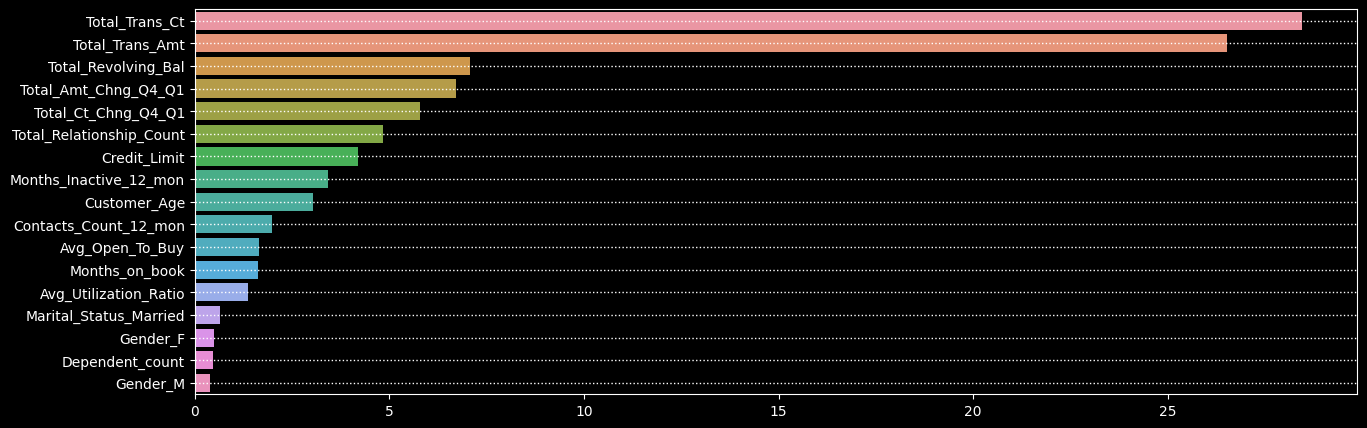

In [11]:
importances = importances.applymap(lambda x: x if x>=0.2980692275 else 0)
importances = importances.loc[:, (importances != 0).all(axis=0)]
plt.figure(figsize=(15,5))
sns.barplot(data=importances.sort_values(by=[0], axis=1, ascending=False), orient='h')
plt.grid(axis='y', color='white', linestyle='dotted', lw=1)
plt.show()

In [12]:
X_train1, X_val1, X_test1 = X_train[importances.columns], X_val[importances.columns], X_test[importances.columns]

In [13]:
fitted_reduced_model1 = model.fit(X_train1, y_train)
y_pred1 = fitted_reduced_model1.predict(X_val1)

In [14]:
X_train2, X_val2, X_test2 = X_train[permutation_based_importances.columns], X_val[permutation_based_importances.columns], X_test[permutation_based_importances.columns]

In [15]:
fitted_reduced_model2 = model.fit(X_train2, y_train)
y_pred2 = fitted_reduced_model2.predict(X_val2)

In [16]:
print('Model 0: ', roc_auc_score(y_pred, y_val))
print('Model 1: ', roc_auc_score(y_pred1, y_val))
print('Model 2: ', roc_auc_score(y_pred2, y_val))

Model 0:  0.965912819350627
Model 1:  0.9670569408160196
Model 2:  0.9680082559339526


Model with the least explanatory variables (12) has really similar ROC AUC score as the most complex one (model 0 with 37 variables) and first one (with 17 variables).\
Hence, to simplify further analysis model 2 should be chose - to improve its performance tuning of hyperparameters should be done.

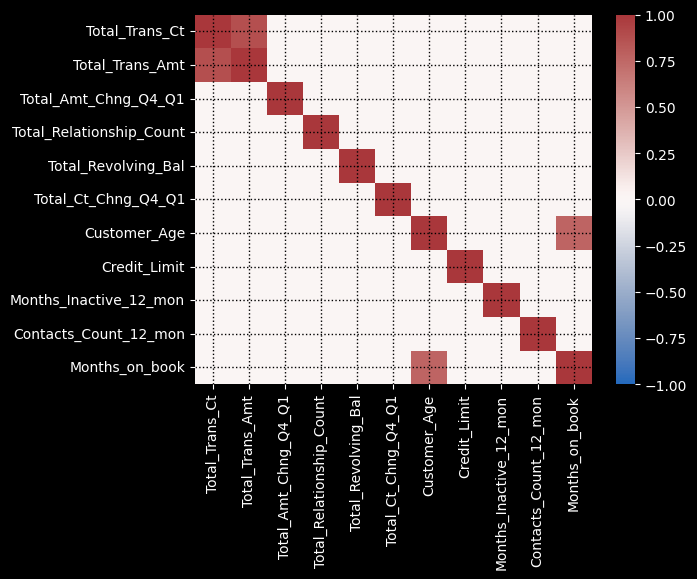

In [17]:
corr_mat = X_train2.corr('spearman', numeric_only=True)
corr_mat[np.abs(corr_mat) < 0.5] = 0
sns.heatmap(corr_mat, cmap="vlag", vmin=-1)
plt.grid(lw=1, color='black', linestyle='dotted')
plt.show()

From correlation matrix there are pairs of features which are strongly correlated:  
Months_On_Book and Customer_Age  
Avg_Open_To_Buy and Credit_Limit  
Total_Trans_Ct and Total_Trans_Amt  
During interpreting results dependences can be inaccurate in case of those particular features, but they are too important to drop them.

In [18]:
#defining objective function (it returns auc on a validation set)

def objective(trial: optuna.Trial) -> float:
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.5, log=True),
        "depth": trial.suggest_int("depth", 1, 6),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2, 10),
        "random_strength": trial.suggest_float("random_strength", 0, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "eval_metric": "Accuracy",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = CatBoostClassifier(**param)

    pruning_callback = CatBoostPruningCallback(trial, "Accuracy")
    gbm.fit(
        X_train2,
        y_train,
        verbose=0,
        eval_set=[(X_val2, y_val)],
        early_stopping_rounds=100,
        callbacks=[pruning_callback]
    )

    pruning_callback.check_pruned()

    preds = gbm.predict(X_val2)
    auc = roc_auc_score(y_val, preds)

    return auc

In [19]:
import warnings
warnings.filterwarnings("ignore")

#searching for hyperparameters which maximize auc function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")

for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

warnings.filterwarnings('default')

[I 2023-04-25 19:52:19,285] A new study created in memory with name: no-name-6e82b142-b080-4c4f-9fac-5923a085cf43
[I 2023-04-25 19:52:30,701] Trial 0 finished with value: 0.9308995837401716 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.19496125687242785, 'depth': 4, 'l2_leaf_reg': 9, 'random_strength': 5.179222934004751, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3990666087064378}. Best is trial 0 with value: 0.9308995837401716.
[I 2023-04-25 19:52:30,993] Trial 1 finished with value: 0.5 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.019807439450000897, 'depth': 6, 'l2_leaf_reg': 10, 'random_strength': 3.6710215232910337, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.16489585013731162}. Best is trial 0 with value: 0.9308995837401716.
[I 2023-04-25 19:52:35,679] Trial 2 finished with value: 0.8776208952155813 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.13946223379590725,

Number of finished trials:  1000
Best trial:
  Value: 0.9497340562207718
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.41285727126497757
    depth: 6
    l2_leaf_reg: 3
    random_strength: 1.306072290188399
    boosting_type: Ordered
    bootstrap_type: MVS


In [23]:
#checking the optimized model's performance

optimized_model = CatBoostClassifier(iterations=850, verbose=False, **trial.params).fit(X_train2, y_train)
y_pred_opt = optimized_model.predict(X_val2)
print('Metrics on a validation set: ')
print('Precision: ', precision_score(y_pred_opt, y_val))
print('Recall: ', recall_score(y_pred_opt, y_val))
print('F1 score: ', f1_score(y_pred_opt, y_val))
print('Accuracy: ', accuracy_score(y_pred_opt, y_val))
print('AUC: ', roc_auc_score(y_pred_opt, y_val))

Metrics on a validation set: 
Precision:  0.9057377049180327
Recall:  0.9608695652173913
F1 score:  0.9324894514767932
Accuracy:  0.9789473684210527
AUC:  0.9715200539265252


In [24]:
#ensuring there isn't an overfitting problem in optimized model by doing cross-validation

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=999)
cv_results = cross_validate(optimized_model, X_train, y_train, scoring='roc_auc', cv=cv, return_train_score=True)

#checking discrepancy between train and validation results

print('Performance on a train set: ', cv_results['train_score']*100, '%')
print('Performance on a validation set: ', cv_results['test_score']*100, '%')
print('Differences: ', (cv_results['train_score']-cv_results['test_score'])*100, 'percentage points')

Performance on a train set:  [99.92751298 99.95847444 99.90889667 99.93512046 99.94060183 99.94718263
 99.93213062 99.91562006 99.92820554 99.93199774 99.90950749 99.94240518
 99.88701725 99.92339364 99.9084322  99.95053475 99.9158526  99.9098588
 99.89183421 99.92987163 99.93746185 99.91435768 99.90751427 99.90833267
 99.91040445 99.88711691 99.93490724 99.86612159 99.94359168 99.92571728] %
Performance on a validation set:  [99.31854978 99.30912758 99.35573749 99.03575125 99.41171006 99.23705055
 99.17297025 99.40733073 99.29133785 98.9850572  99.44130371 99.37409937
 99.22565491 99.16208828 99.4140165  99.1911511  99.16381347 99.49717719
 99.37561377 99.41701834 99.14484197 99.32929904 99.13859915 99.31355839
 99.33965018 99.3685803  99.13446352 99.46598721 99.3685803  98.92276966] %
Differences:  [0.6089632  0.64934685 0.55315919 0.89936921 0.52889177 0.71013208
 0.75916037 0.50828932 0.63686769 0.94694054 0.46820378 0.56830581
 0.66136234 0.76130537 0.4944157  0.75938365 0.7520391

Differences between train and validation sets are realtively low, so there is not an overfitting problem.

In [25]:
#initializing explainer for chosen model (model analysis will be done on a validation set)
model2_exp = dx.Explainer(optimized_model, X_val2, y_val, label='CBC-optimized')

Preparation of a new explainer is initiated

  -> data              : 1520 rows 11 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1520 values
  -> model_class       : catboost.core.CatBoostClassifier (default)
  -> label             : CBC-optimized
  -> predict function  : <function yhat_proba_default at 0x0000019A9BEDE050> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 7.5e-07, mean = 0.158, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.931, mean = 0.00294, max = 0.988
  -> model_info        : package catboost

A new explainer has been created!


Checking residuals - there should be no pattern in residuals.  
Otherwise, it means that model is biased - it overestimates or underestimates predictions.

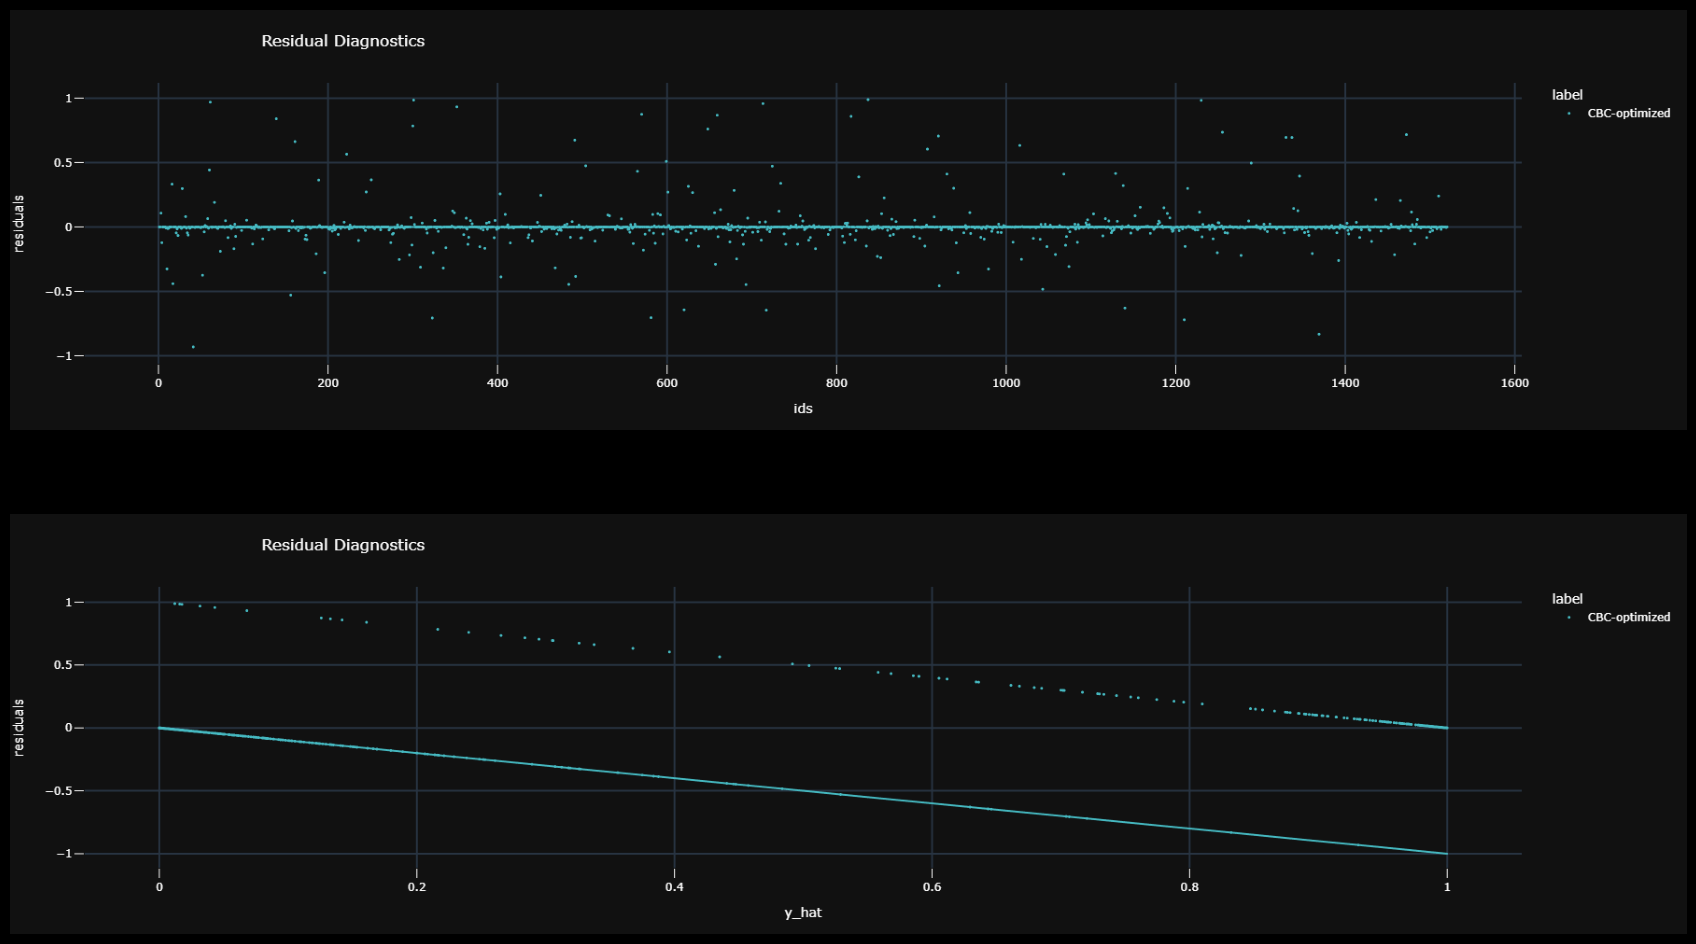

In [39]:
#residuals' plot 
model_exp_diagnostic = model2_exp.model_diagnostics()

#dynamic plots
#model_exp_diagnostic.plot(variable='ids', yvariable='residuals', show=False).update_layout(template='plotly_dark', font_color='white').show()
#model_exp_diagnostic.plot(variable='y_hat', yvariable='residuals', show=False).update_layout(template='plotly_dark', font_color='white')

#displaying static plots
import matplotlib.image as mpimg
img = mpimg.imread("C:/Users/pc/Churn-Classification/Static_Plots/residuals1.png")
img2 = mpimg.imread("C:/Users/pc/Churn-Classification/Static_Plots/residuals2.png")
plt.figure(figsize=(25,12))
plt.subplot(2,1,1)
imgplot = plt.imshow(img)
plt.axis('off')
plt.subplot(2,1,2)
imgplot2 = plt.imshow(img2)
plt.axis('off')
plt.show()

Second plot indices that the higher predicted value(y_hat) is, the more negative residuals are.  
It means, that model is better at predicting zeros than ones (compare precision and recall above - recall is higher).

Calculating ceteris paribus: 100%|██████████| 11/11 [00:00<00:00, 44.77it/s]


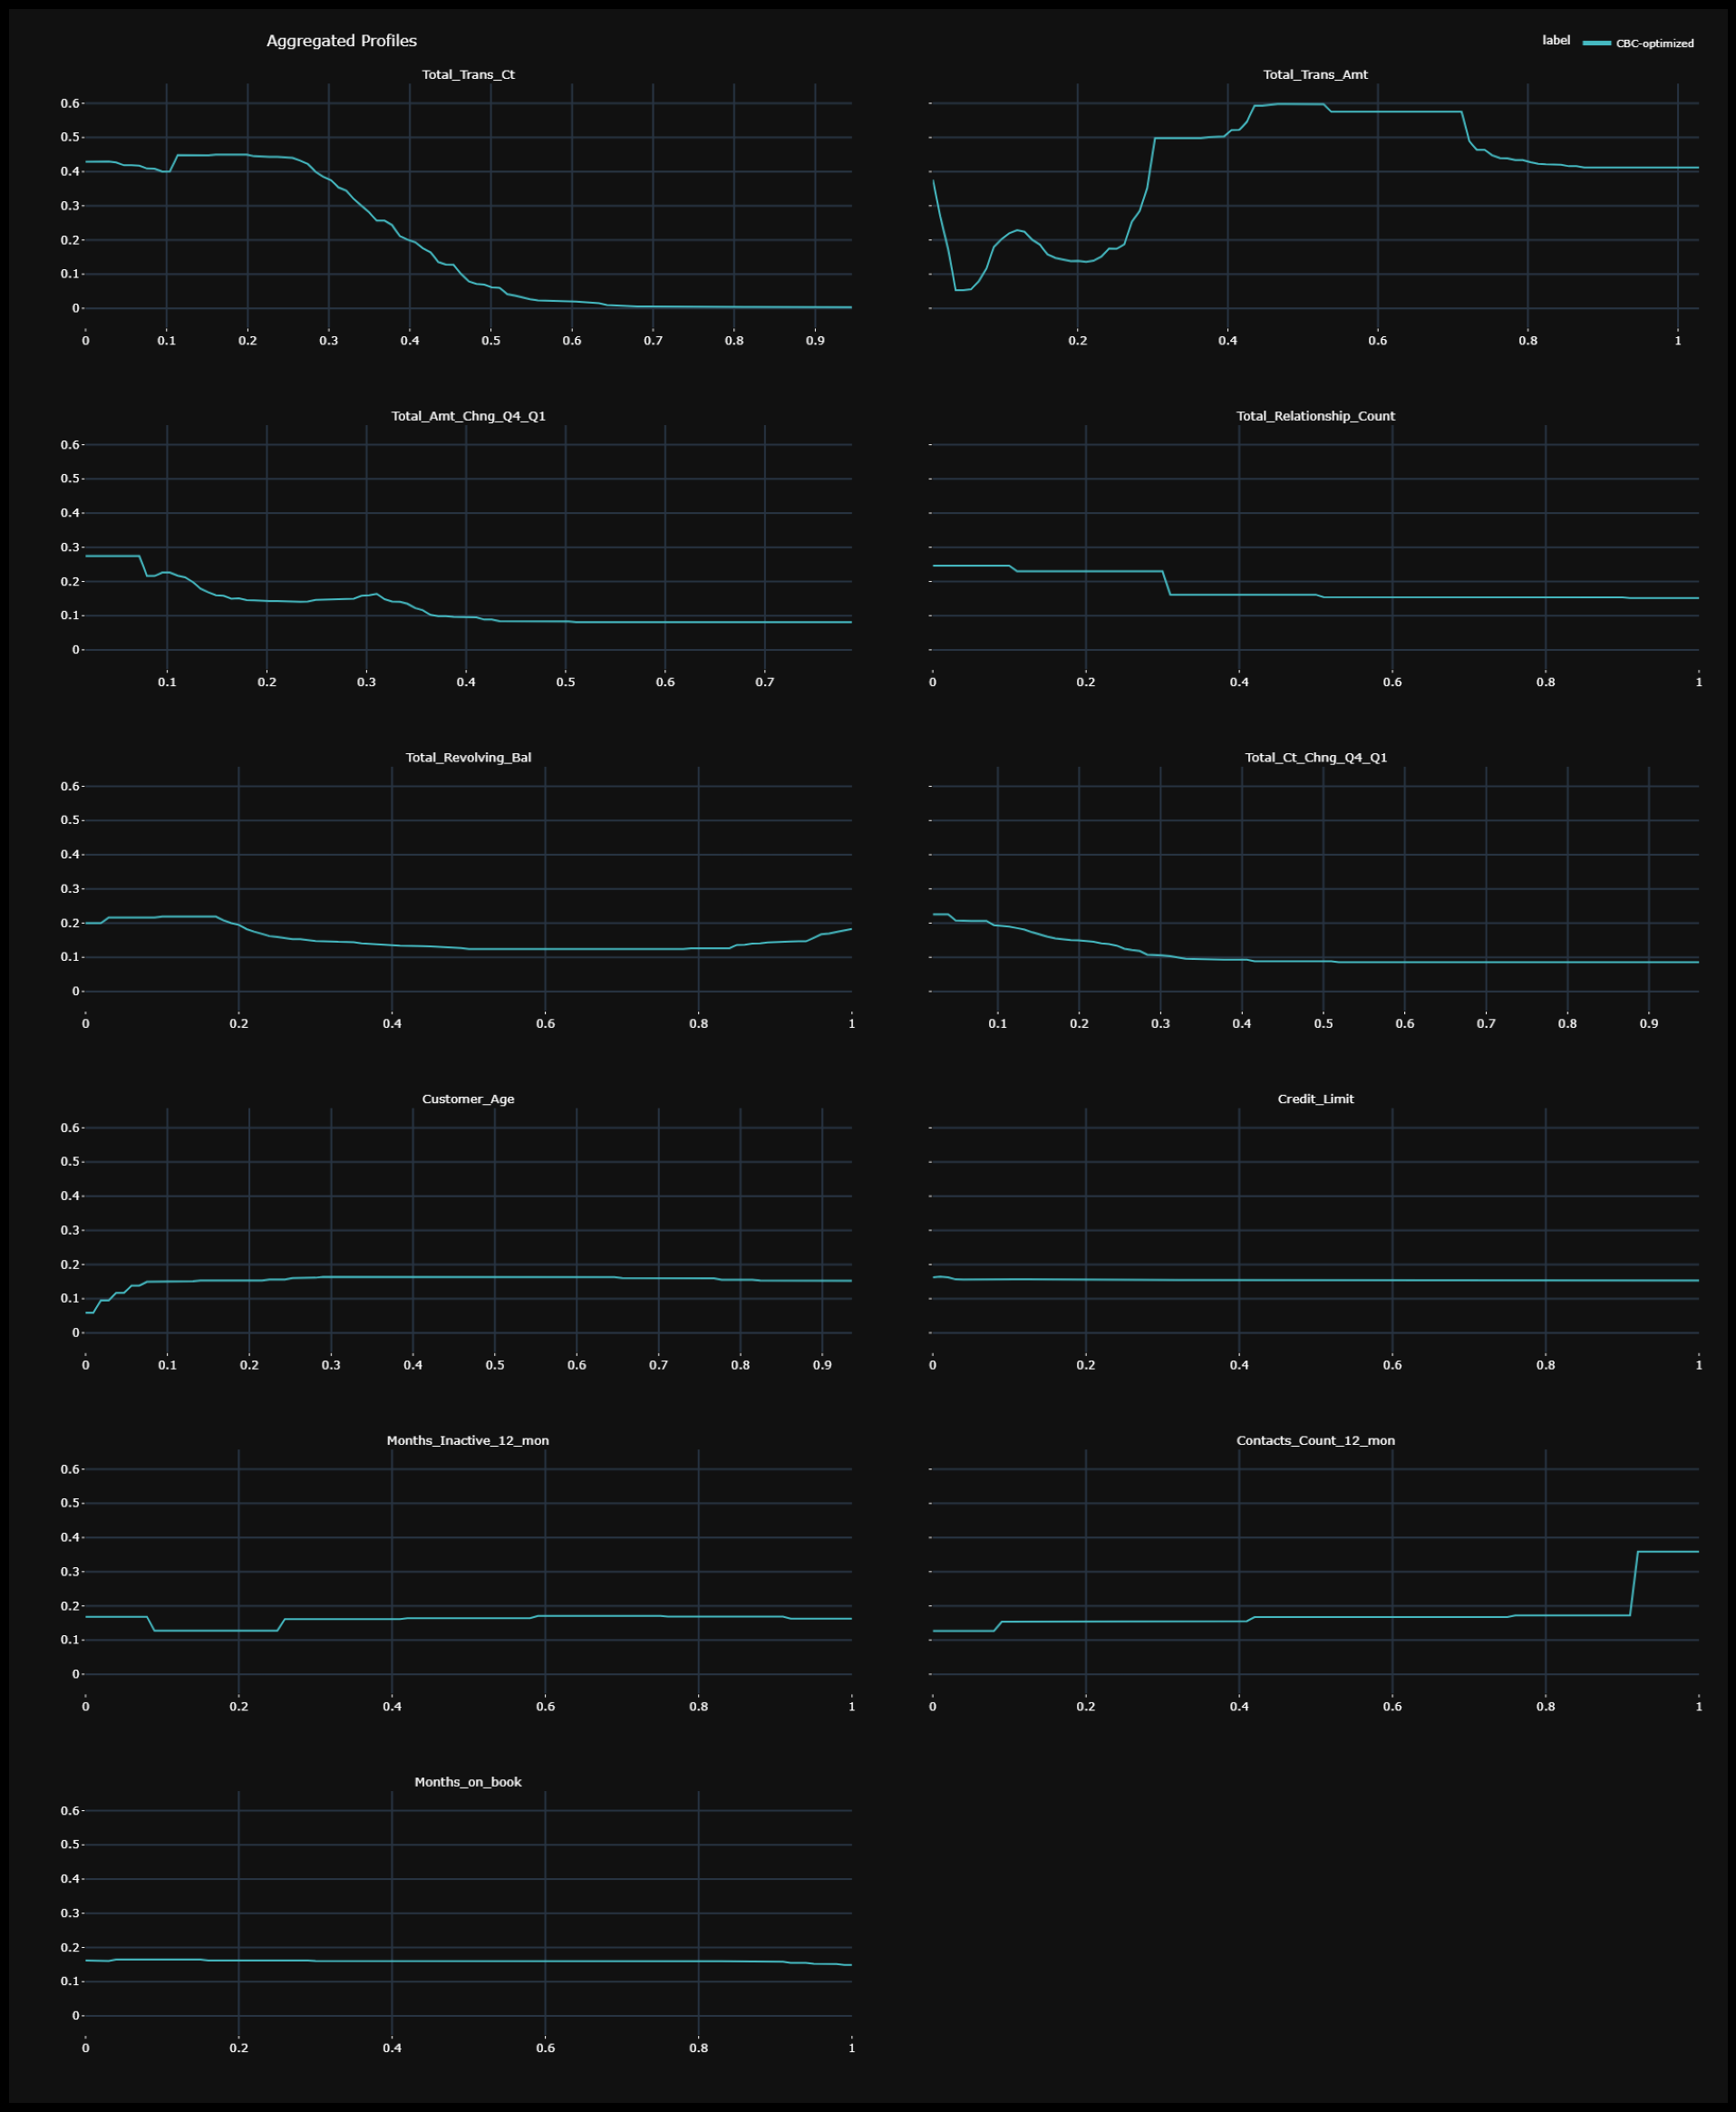

In [40]:
#partial dependence
model_exp_PD = model2_exp.model_profile()
#dynamic plot
#model_exp_PD.plot(show=False).update_layout(template='plotly_dark', font_color='white')

#static plot
img = mpimg.imread("C:/Users/pc/Churn-Classification/Static_Plots/partial_dependences.png")
plt.figure(figsize=(25,30))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

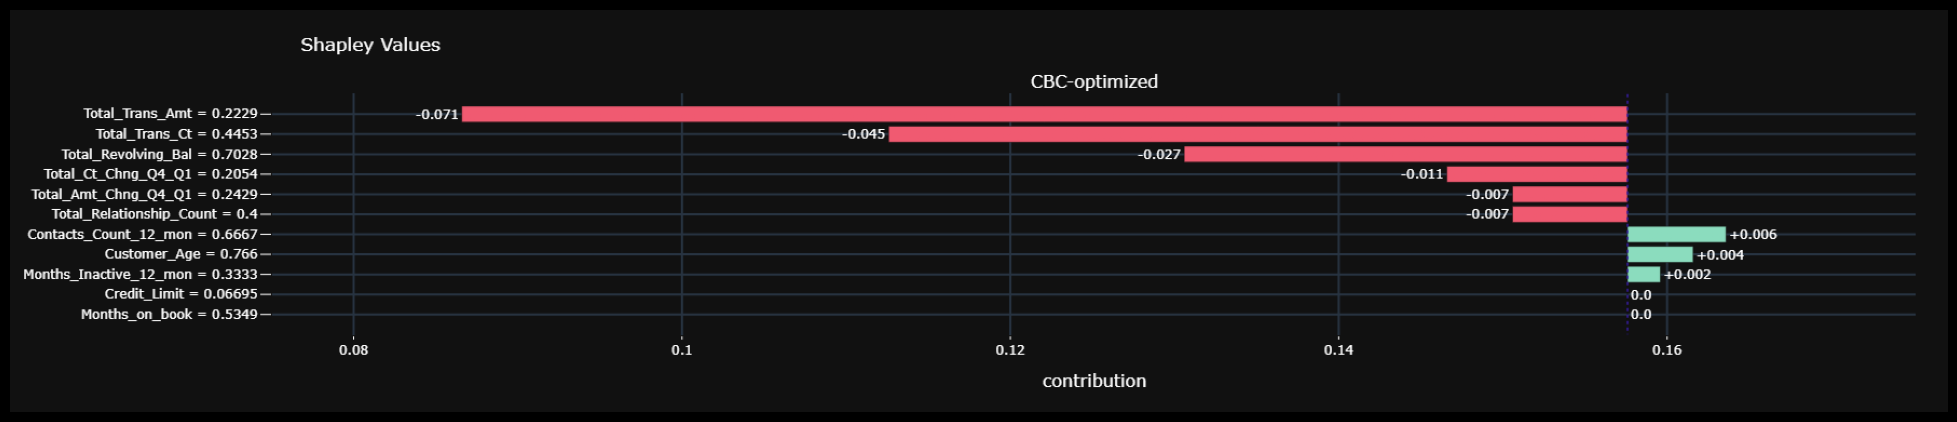

In [41]:
single_datapoint = X_val2.sample(random_state=42)
shap = model2_exp.predict_parts(single_datapoint, type = 'shap')
#dynamic plot
#shap.plot(max_vars=20, show=False).update_layout(template='plotly_dark', font_color='white')

#static plot
img = mpimg.imread("C:/Users/pc/Churn-Classification/Static_Plots/shapley.png")
plt.figure(figsize=(25,10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [29]:
model_exp_bd = model2_exp.predict_parts(single_datapoint, type='break_down')
#dynamic plot
#model_exp_bd.plot(max_vars=20, show=False).update_layout(template='plotly_dark', font_color='white')

#static plot
img = mpimg.imread("C:/Users/pc/Churn-Classification/Static_Plots/break_down.png")
plt.figure(figsize=(25,10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()